## Load dataset (train & eval)

In [1]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

dataset_root = Path("/home/melon/sherry/so101_bench/datasets/recordings/")
dataset_name = "2025-09-01_pick-and-place-block"
eval_set_prefix = "eval_2025-09-14_smolvla"
checkpoint_suffix = ""

dataset_path = dataset_root / dataset_name

In [2]:
# Load the stratified sampling output
stratified_sampling_output_path = dataset_path / "stratified_sampling_output.yaml"
splits_path = dataset_path / "splits.yaml"
with open(stratified_sampling_output_path, 'r') as f:
    stratified_sampling_output = yaml.safe_load(f)
with open(splits_path, 'r') as f:
    splits = yaml.safe_load(f)

print("Loaded stratified sampling stratified_sampling_output")
print(f"Number of bins: {len(stratified_sampling_output['sampling_outputs'])}")
print(f"Stratification axes: {list(stratified_sampling_output['stratification_config']['axes'].keys())}")
print(f"Overall x range: {stratified_sampling_output['stratification_config']['axes']['start_pose.block.x']}")
print(f"Overall y range: {stratified_sampling_output['stratification_config']['axes']['start_pose.block.y']}")
print(f"Number of val_id: {len(splits['val_id'])}")
print(f"Number of train: {len(splits['train'])}")
print(f"Number of val_ood: {len(splits['val_ood'])}")

# Bin index to start pose xy range
bin_to_range = {}
for bin_idx, bin_data in stratified_sampling_output['sampling_outputs'].items():
    bin_to_range[bin_idx] = {
        'start_pose.block.x': bin_data['bin_ranges']['start_pose.block.x'],
        'start_pose.block.y': bin_data['bin_ranges']['start_pose.block.y']
    }

# mapping from episode name to split
episode_name_to_split = {}
for key in ["val_id", "val_ood", "train"]:
    for episode_name in splits[key]:
        episode_name_to_split[episode_name] = key

print(len(episode_name_to_split))

Loaded stratified sampling stratified_sampling_output
Number of bins: 6
Stratification axes: ['start_pose.block.x', 'start_pose.block.y']
Overall x range: [0.023, 0.2]
Overall y range: [0.034, 0.266]
Number of val_id: 10
Number of train: 126
Number of val_ood: 12
148


In [3]:
def look_up_bin_idx(x, y, bin_to_range):
    for bin_idx, bin_data in bin_to_range.items():
        if bin_data['start_pose.block.x'][0] <= x < bin_data['start_pose.block.x'][1] and \
            bin_data['start_pose.block.y'][0] <= y < bin_data['start_pose.block.y'][1]:
            return bin_idx
    return None

# Function to load episode task config
def load_episode_task_config(dataset_root, dataset_name, episode_name):
    episode_dir = dataset_root / dataset_name / "episodes" / episode_name
    task_config_path = os.path.join(episode_dir, "task_config.yaml")
    with open(task_config_path, 'r') as f:
        return yaml.safe_load(f)

def load_episode_eval_score(dataset_root, dataset_name, episode_name):
    episode_dir = dataset_root / dataset_name / "episodes" / episode_name
    eval_score_path = os.path.join(episode_dir, "eval_score.yaml")
    with open(eval_score_path, 'r') as f:
        return yaml.safe_load(f)

In [4]:

# Extract pose data from all episodes
block_poses = {"train": {}, "val_id": {}, "val_ood": {}} 
container_poses = {"train": [], "val_id": [], "val_ood": []}
episode_names = []

dataset_episodes_path = dataset_root / dataset_name / "episodes"
# for bin_idx, bin_data in stratified_sampling_output['sampling_outputs'].items():
    # for episode_name in bin_data['episodes']:
for item in dataset_episodes_path.iterdir():
    episode_name = item.name
    
    try:
        task_config = load_episode_task_config(dataset_root, dataset_name, episode_name)
        block_start_x = task_config['variations']['start_pose']['block'][0]
        block_start_y = task_config['variations']['start_pose']['block'][1]
        bin_idx = look_up_bin_idx(block_start_x, block_start_y, bin_to_range)
        if bin_idx is None:
            raise ValueError(f"Episode {episode_name} not in any bin")
        
        # Extract block pose (x, y, yaw)
        block_pose = task_config['variations']['start_pose']['block']
        block_x, block_y, block_yaw = block_pose[0], block_pose[1], block_pose[2]
        
        # Extract container pose (x, y, yaw)  
        container_pose = task_config['variations']['start_pose']['container']
        container_x, container_y, container_yaw = container_pose[0], container_pose[1], container_pose[2]

        split = episode_name_to_split.get(episode_name, None)
        if split is None:
            print(f"Episode {episode_name} not in any split")
            continue
        if bin_idx not in block_poses[split]:
            block_poses[split][bin_idx] = []
        
        block_poses[split][bin_idx].append((block_x, block_y, block_yaw))
        container_poses[split].append((container_x, container_y, container_yaw))
        episode_names.append(episode_name)
        
    except Exception as e:
        print(f"Error loading {episode_name}: {e}")
        raise

eval_poses_and_results = {"val_id": [], "val_ood": []} # (x,y,yaw,success)

for val_type in ["id", "ood"]:
    eval_set_name = f"{eval_set_prefix}_{val_type}"
    eval_set_episodes_path = dataset_root / eval_set_name / "episodes"
    for item in eval_set_episodes_path.iterdir():
        episode_name = item.name
        task_config = load_episode_task_config(dataset_root, eval_set_name, episode_name)
        block_pose = task_config['variations']['start_pose']['block']
        block_x, block_y, block_yaw = block_pose[0], block_pose[1], block_pose[2]
        # container_pose = task_config['variations']['start_pose']['container']
        # container_x, container_y, container_yaw = container_pose[0], container_pose[1], container_pose[2]

        eval_score = load_episode_eval_score(dataset_root, eval_set_name, episode_name)
        success = eval_score['episode_metrics']["success"]
        if not success:
            print(f"Episode {episode_name} failed")
        task_progress_score = eval_score['episode_metrics']["task_progress_score"]
        eval_poses_and_results["val_" + val_type].append((block_x, block_y, block_yaw, success, task_progress_score))
    
print(f"[train] Successfully loaded {len(block_poses)} episodes")
print(f"[eval] Successfully loaded {len(eval_poses_and_results)} episodes")

Episode 154_2025-09-07_17-40-36 not in any split
Episode 151_2025-09-07_17-35-26 not in any split
Episode 157_2025-09-07_17-44-23 not in any split
Episode 149_2025-09-07_17-31-29 not in any split
Episode 152_2025-09-07_17-37-53 not in any split
Episode 153_2025-09-07_17-39-15 not in any split
Episode 156_2025-09-07_17-43-12 not in any split
Episode 148_2025-09-07_17-30-03 not in any split
Episode 155_2025-09-07_17-41-41 not in any split
Episode 150_2025-09-07_17-34-19 not in any split


FileNotFoundError: [Errno 2] No such file or directory: '/home/melon/sherry/so101_bench/datasets/recordings/eval_2025-09-14_smolvla_id/episodes/2025-09-01_pick-and-place-block__067_2025-09-04_20-38-31__eval__006_2025-09-16_21-02-43/eval_score.yaml'

## Create the 2D plot

In [12]:
def plot_block_poses(block_poses, container_poses, eval_poses_and_results, sampled_poses=None):
    # Create the 2D plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Set up the plot with origin at bottom left
    ax.set_xlim(0.0, 0.35)
    ax.set_ylim(0.0, 0.28)
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_title('Block Starting Poses: Training Data and Evaluation Results')
    major_ticks = np.arange(0, 0.35, 0.05)
    minor_ticks = np.arange(0, 0.35, 0.01)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(True, which='both', alpha=0.3)

    from matplotlib.lines import Line2D
    legend_elements = []

    # Get the bin ranges from the stratification config
    x_range = stratified_sampling_output['stratification_config']['axes']['start_pose.block.x']
    y_range = stratified_sampling_output['stratification_config']['axes']['start_pose.block.y']
    x_bin_size = stratified_sampling_output['stratification_config']['bin_sizes']['start_pose.block.x']
    y_bin_size = stratified_sampling_output['stratification_config']['bin_sizes']['start_pose.block.y']

    # Calculate bin boundaries
    x_bins = np.linspace(x_range[0], x_range[1], num=int((x_range[1] - x_range[0]) / x_bin_size) + 1)
    y_bins = np.linspace(y_range[0], y_range[1], num=int((y_range[1] - y_range[0]) / y_bin_size) + 1)

    # Draw dotted lines for bin boundaries
    for x in x_bins:
        ax.axvline(x=x, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    for y in y_bins:
        ax.axhline(y=y, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Define colors for different bins
    bin_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    def _determine_marker(set_type):
        if set_type == "train":
            return 'o' # train
        if set_type == "val_id":
            return 's'
        elif set_type == "val_ood":
            return 'd'
        else:
            raise ValueError(f"Invalid set type: {set_type}")

    def _draw_arrows_for_bin(bin_idx, color, arrow_length, poses_in_bin, set_type, marker):
        bin_x = [p[0] for p in poses_in_bin]
        bin_y = [p[1] for p in poses_in_bin]
        
        color = bin_colors[int(bin_idx) % len(bin_colors)]
        
        alpha = 0.8 if set_type == "train" else 0.3
            
        ax.scatter(bin_x, bin_y, c=color, marker=marker, s=60, alpha=alpha, 
                label=f'{set_type} Bin {bin_idx}')
        
        # Add arrows to indicate yaw for block poses
        
        for x, y, yaw in poses_in_bin:
            yaw_rad = np.deg2rad(yaw + 90)
            dy = arrow_length * np.sin(yaw_rad)
            dx = arrow_length * np.cos(yaw_rad)
            ax.arrow(x, y, dx, dy, head_width=0.005, head_length=0.003, 
                    fc=color, ec=color, alpha=alpha, length_includes_head=True)
        
        # Add legend
        legend_elements.append(Line2D([0], [0], marker=marker, color='w', 
                                            markerfacecolor=color, markersize=8, 
                                            label=f'{set_type} Bin {bin_idx}'))


    # Plot training block poses with different colors for different bins
    arrow_length = 0.01
    for set_type in ["train", "val_id", "val_ood"]:
        for bin_idx in sorted(block_poses[set_type].keys()):
            poses_in_bin = block_poses[set_type][bin_idx]
            if poses_in_bin:  # Only plot if there are poses in this bin
                color = bin_colors[int(bin_idx) % len(bin_colors)]
                marker = _determine_marker(set_type)
                _draw_arrows_for_bin(
                    bin_idx, color, arrow_length,
                    poses_in_bin, set_type, marker
                )
                
    if sampled_poses:
        for x, y, yaw in sampled_poses:
            yaw_rad = np.deg2rad(yaw + 90)
            dy = arrow_length * np.sin(yaw_rad)
            dx = arrow_length * np.cos(yaw_rad)
            ax.arrow(x, y, dx, dy, head_width=0.005, head_length=0.003, 
                    fc='black', ec='black', alpha=0.8, length_includes_head=True)

    # Plot container poses from training data as black-edge-enclosed squares
    all_container_x = []
    all_container_y = []
    for split in ["train"]:  # Only plot training container poses
        for x, y, yaw in container_poses[split]:
            all_container_x.append(x)
            all_container_y.append(y)

    if all_container_x:  # Only plot if we have container data
        ax.scatter(all_container_x, all_container_y, c='lightgray', marker='s', s=80, 
                alpha=0.7, edgecolors='black', linewidth=2, label='Container poses')

    # Plot evaluation poses and results
    for eval_type in ["val_id", "val_ood"]:
        if eval_type in eval_poses_and_results:
            poses_results = eval_poses_and_results[eval_type]
            
            marker = _determine_marker(eval_type)

            for x, y, yaw, success, task_progress_score in poses_results:
                base_color = 'cyan' if success else 'magenta'
                
                # Use task_progress_score to determine color darkness (0.3 to 1.0 alpha)
                # alpha = 0.3 + 0.7 * task_progress_score
                
                # Plot the point
                ax.scatter(x, y, c=base_color, marker=marker, s=100, linewidth=1, edgecolors='black')


    # Add container poses legend entry
    if all_container_x:
        legend_elements.append(Line2D([0], [0], marker='s', color='w', 
                                    markerfacecolor='lightgray', markersize=8,
                                    markeredgecolor='black', markeredgewidth=2,
                                    label='Container poses'))

    # Add evaluation data legend entries
    legend_elements.extend([
        Line2D([0], [0], marker=_determine_marker("val_id"), color='w', markerfacecolor='cyan', 
            markersize=10, label='Val ID (success)', markeredgecolor='black'),
        Line2D([0], [0], marker=_determine_marker("val_id"), color='w', markerfacecolor='magenta', 
            markersize=10, label='Val ID (failure)', markeredgecolor='black'),
        Line2D([0], [0], marker=_determine_marker("val_ood"), color='cyan', markersize=10, 
            label='Val OOD (success)', markeredgewidth=2),
        Line2D([0], [0], marker=_determine_marker("val_ood"), color='magenta', markersize=10, 
            label='Val OOD (failure)', markeredgewidth=2),
    ])

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add bin labels
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            bin_x = x_bins[i] + x_bin_size/2
            bin_y = y_bins[j] + y_bin_size/2
            bin_num = i * (len(y_bins)-1) + j
            if bin_num < 6:  # Only label the 6 bins we have
                ax.text(bin_x, bin_y, f'Bin {bin_num}', 
                    ha='center', va='center', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"Training data:")
    for bin_idx, poses_in_bin in block_poses["train"].items():
        print(f"  Bin {bin_idx}: {len(poses_in_bin)} episodes")

    print(f"\nEvaluation data:")
    for eval_type in ["val_id", "val_ood"]:
        if eval_type in eval_poses_and_results:
            poses_results = eval_poses_and_results[eval_type]
            successes = sum(1 for _, _, _, success, _ in poses_results if success)
            total = len(poses_results)
            avg_progress = np.mean([task_progress_score for _, _, _, _, task_progress_score in poses_results])
            print(f"  {eval_type}: {successes}/{total} successful, avg task progress: {avg_progress:.3f}")

    print(f"\nX bin boundaries: {x_bins}")
    print(f"Y bin boundaries: {y_bins}")


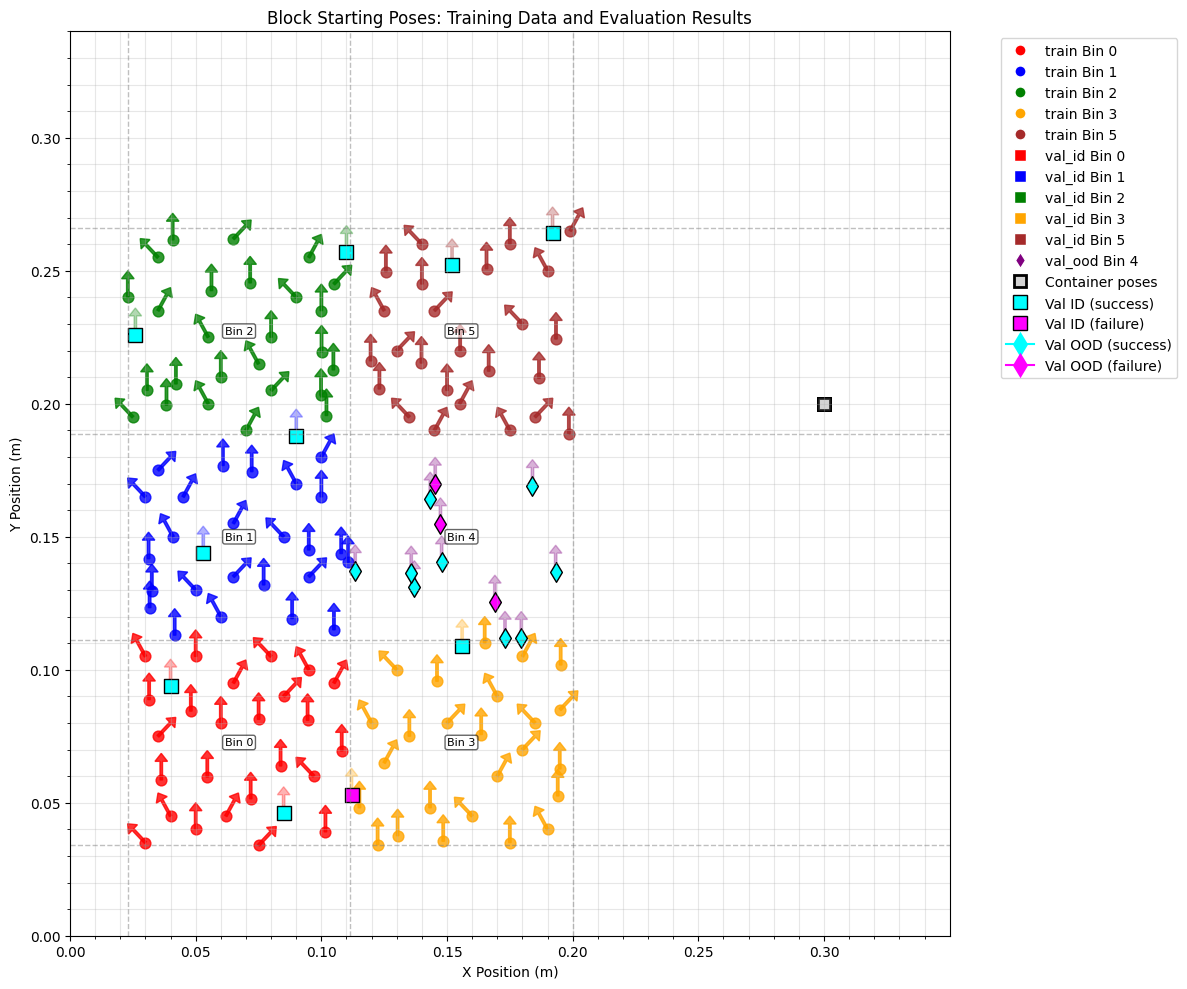

Training data:
  Bin 3: 25 episodes
  Bin 1: 25 episodes
  Bin 2: 26 episodes
  Bin 5: 25 episodes
  Bin 0: 25 episodes

Evaluation data:
  val_id: 9/10 successful, avg task progress: 0.920
  val_ood: 9/12 successful, avg task progress: 0.800

X bin boundaries: [0.023  0.1115 0.2   ]
Y bin boundaries: [0.034      0.11133333 0.18866667 0.266     ]


In [14]:
plot_block_poses(block_poses, container_poses, eval_poses_and_results=eval_poses_and_results, sampled_poses=None)

## Analyze latency

In [7]:
from typing import List, Dict, Any

def calculate_frame_latency_ms(sync_logs: List[Dict[str, Any]]) -> list[float]:
    """Calculate frame latency entries (in ms) from sync logs."""
    latencies_ms = []

    for log_entry in sync_logs:
        timestamps = []
        
        # Collect all timestamps from the log entry
        if "timestamp" in log_entry:
            timestamps.append(log_entry["timestamp"])
        if "robot_state_timestamp" in log_entry:
            timestamps.append(log_entry["robot_state_timestamp"])
        if "action_timestamp" in log_entry:
            timestamps.append(log_entry["action_timestamp"])
        if "camera_timestamps" in log_entry:
            timestamps.extend(log_entry["camera_timestamps"].values())
        
        if len(timestamps) >= 2:
            latency_s = max(timestamps) - min(timestamps)
            latencies_ms.append(latency_s * 1000)  # Convert to milliseconds

    # return sum(latencies) / len(latencies) if latencies else 0.0
    return latencies_ms

In [11]:
import numpy as np
from so101_bench.file_utils import load_jsonl

frame_latencies_ms = []

# Just analyzing the latency on eval set
for eval_type in ["id", "ood"]:
    eval_set_name = f"{eval_set_prefix}_{eval_type}{checkpoint_suffix}"
    eval_set_episodes_path = dataset_root / eval_set_name / "episodes"
    for item in eval_set_episodes_path.iterdir():
        episode_name = item.name
        episode_dir = eval_set_episodes_path / episode_name
        sync_log_path = episode_dir / "sync_logs.jsonl"
        sync_log = load_jsonl(sync_log_path)
        curr_episode_latencies = calculate_frame_latency_ms(sync_log)
        print(f"Latency for {episode_name}: mean: {np.average(curr_episode_latencies)} ms, std: {np.std(curr_episode_latencies)} ms, ({len(curr_episode_latencies)} entries)")
        frame_latencies_ms.extend(calculate_frame_latency_ms(sync_log))


Latency for 2025-09-01_pick-and-place-block__067_2025-09-04_20-38-31__eval__006_2025-09-16_21-02-43: mean: 66.14281615366116 ms, std: 26.75584235216835 ms, (587 entries)
Latency for 2025-09-01_pick-and-place-block__061_2025-09-04_20-29-53__eval__000_2025-09-16_20-49-40: mean: 63.514380512574036 ms, std: 30.79142422444893 ms, (1077 entries)
Latency for 2025-09-01_pick-and-place-block__070_2025-09-04_20-42-55__eval__007_2025-09-16_21-04-09: mean: 62.431235798556905 ms, std: 26.83688040847473 ms, (1091 entries)
Latency for 2025-09-01_pick-and-place-block__063_2025-09-04_20-33-16__eval__002_2025-09-16_20-53-31: mean: 63.721818217201616 ms, std: 26.366905287748423 ms, (1093 entries)
Latency for 2025-09-01_pick-and-place-block__060_2025-09-04_20-27-39__eval__000_2025-09-16_20-42-37: mean: 65.53657176882722 ms, std: 30.46335567379796 ms, (1075 entries)
Latency for 2025-09-01_pick-and-place-block__062_2025-09-04_20-31-42__eval__001_2025-09-16_20-51-20: mean: 63.40159950675545 ms, std: 26.79565

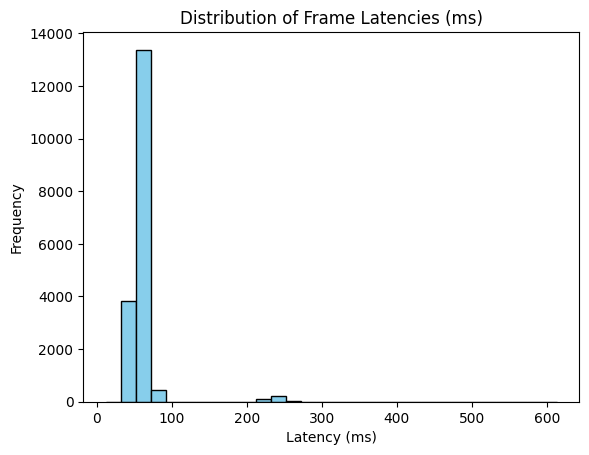

In [12]:
# Create a basic histogram
plt.hist(frame_latencies_ms, bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of Frame Latencies (ms)')

# Display the plot
plt.show()

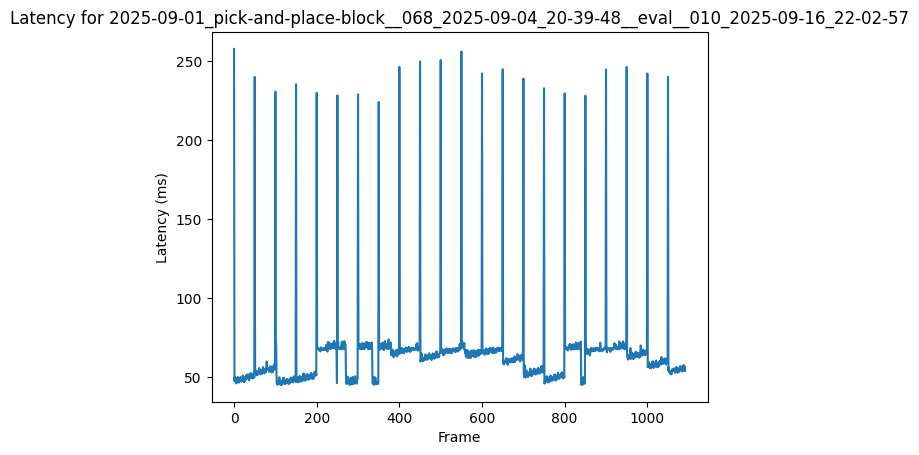

In [13]:
plt.plot(curr_episode_latencies)
plt.title(f"Latency for {episode_name}")
plt.xlabel("Frame")
plt.ylabel("Latency (ms)")
plt.show()

## Randomly generate block start poses for data collection

In [17]:
bin_idx = 1

bin_ranges = bin_to_range[bin_idx]
print(f"bin ranges:")
for key in bin_ranges:
    print(f"{key}: {bin_ranges[key][0]:.3f}, {bin_ranges[key][1]:.3f}")
print("--------------------------------")
angle_ranges = [-45,-30,0,30,45]

sampled_poses = []
for i in range(15):
    angle = angle_ranges[i % 5]
    x = np.random.uniform(bin_ranges['start_pose.block.x'][0], bin_ranges['start_pose.block.x'][1])
    y = np.random.uniform(bin_ranges['start_pose.block.y'][0], bin_ranges['start_pose.block.y'][1])
    sampled_poses.append((x, y, angle))
    print(f"x: {x:.3f}, y: {y:.3f}, angle: {angle}")

bin ranges:
start_pose.block.x: 0.023, 0.112
start_pose.block.y: 0.111, 0.189
--------------------------------
x: 0.090, y: 0.133, angle: -45
x: 0.058, y: 0.168, angle: -30
x: 0.074, y: 0.129, angle: 0
x: 0.037, y: 0.183, angle: 30
x: 0.041, y: 0.144, angle: 45
x: 0.061, y: 0.135, angle: -45
x: 0.107, y: 0.131, angle: -30
x: 0.055, y: 0.182, angle: 0
x: 0.108, y: 0.139, angle: 30
x: 0.085, y: 0.174, angle: 45
x: 0.053, y: 0.126, angle: -45
x: 0.097, y: 0.139, angle: -30
x: 0.082, y: 0.152, angle: 0
x: 0.084, y: 0.140, angle: 30
x: 0.062, y: 0.129, angle: 45


In [ ]:
manual_sampled_poses = [
    # bin 0
    (0.03, 0.035, 45),
    (0.04, 0.045, 30),
    (0.05, 0.04, 0),
    (0.062, 0.045, -30),
    (0.075, 0.034, -45),
    (0.097, 0.06, 45),
    (0.03, 0.105, 30),
    (0.06, 0.08, 0),
    (0.065, 0.095, -30),
    (0.085, 0.09, -45),
    (0.08, 0.105, 45),
    (0.095, 0.10, 30),
    (0.05, 0.105, 0),
    (0.105, 0.095, -30),
    (0.035, 0.075, -45),
    # bin 1
    (0.05, 0.13, 45),
    (0.06, 0.12, 30),
    (0.095, 0.145, 0),
    (0.065, 0.155, -30),
    (0.035, 0.175, -45),
    (0.085, 0.15, 45),
    (0.09, 0.17, 30),
    (0.1, 0.165, 0),
    (0.1, 0.18, -30),
    (0.095, 0.135, -45),
    (0.03, 0.165, 45),
    (0.041, 0.15, 30),
    (0.105, 0.115, 0),
    (0.045, 0.165, -30),
    (0.065, 0.135, -45),
    # bin 2
    (0.035, 0.255, 45),
    (0.055, 0.225, 30),
    (0.023, 0.24, 0),
    (0.035, 0.235, -30),
    (0.08, 0.205, -45),
    (0.09, 0.24, 45),
    (0.075, 0.215, 30),
    (0.06, 0.21, 0),
    (0.095, 0.255, -30),
    (0.105, 0.245, -45),
    (0.025, 0.195, 45),
    (0.055, 0.20, 30),
    (0.08, 0.225, 0),
    (0.07, 0.19, -30),
    (0.065, 0.262, -45),
    (0.1, 0.235, -30), # accident, lol
    # bin 3
    (0.185, 0.08, 45),
    (0.17, 0.09, 30),
    (0.165, 0.11, 0),
    (0.18, 0.105, -30),
    (0.195, 0.085, -45),
    (0.16, 0.045, 45),
    (0.19, 0.04, 30),
    (0.175, 0.035, 0),
    (0.17, 0.06, -30),
    (0.18, 0.07, -45),
    (0.13, 0.10, 45),
    (0.12, 0.08, 30),
    (0.135, 0.075, 0),
    (0.125, 0.065, -30),
    (0.15, 0.08, -45),
    # bin 5
    (0.18, 0.23, 45),
    (0.19, 0.25, 30),
    (0.175, 0.26, 0),
    (0.2, 0.265, -30),
    (0.145, 0.235, -45),
    (0.135, 0.195, 45),
    (0.175, 0.19, 30),
    (0.15, 0.205, 0),
    (0.155, 0.20, -30),
    (0.13, 0.22, -45),
    (0.14, 0.26, 45),
    (0.125, 0.235, 30),
    (0.14, 0.245, 0),
    (0.145, 0.19, -30),
    (0.185, 0.195, -45),
]

# sampled_poses.extend(manual_sampled_poses)
sampled_poses = manual_sampled_poses
# sampled_poses = []

NameError: name 'plot_block_poses' is not defined

In [40]:
22 / 158.0

0.13924050632911392